<a href="https://colab.research.google.com/github/salmaow/klasifikasi_gambar/blob/main/Submission_Klasifikasi_Gambar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Klasifikasi Gambar: Cat & Dog images for Classification
- **Nama:** Salma Oktarina
- **Email:** salmaoktarina14@gmail.com
- **ID Dicoding:** salmaaja14

Sumber Dataset: https://www.kaggle.com/datasets/ashfakyeafi/cat-dog-images-for-classification

## Import Semua Packages/Library yang Digunakan

In [1]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


In [3]:
!pip install tensorflowjs
import tensorflowjs as tfjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


## Data Preparation

### Data Loading

In [4]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"salmaoktarina","key":"347cb858a5522c668de2eab36a43b567"}'}

In [5]:
# Download kaggle dataset and unzip the file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Unduh dataset dari Kaggle
!kaggle datasets download -d ashfakyeafi/cat-dog-images-for-classification
# Unzip file
!unzip cat-dog-images-for-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: cat_dog/dog.5499.jpg    
  inflating: cat_dog/dog.55.jpg      
  inflating: cat_dog/dog.550.jpg     
  inflating: cat_dog/dog.5500.jpg    
  inflating: cat_dog/dog.5501.jpg    
  inflating: cat_dog/dog.5502.jpg    
  inflating: cat_dog/dog.5503.jpg    
  inflating: cat_dog/dog.5504.jpg    
  inflating: cat_dog/dog.5505.jpg    
  inflating: cat_dog/dog.5506.jpg    
  inflating: cat_dog/dog.5507.jpg    
  inflating: cat_dog/dog.5508.jpg    
  inflating: cat_dog/dog.5509.jpg    
  inflating: cat_dog/dog.551.jpg     
  inflating: cat_dog/dog.5510.jpg    
  inflating: cat_dog/dog.5511.jpg    
  inflating: cat_dog/dog.5512.jpg    
  inflating: cat_dog/dog.5513.jpg    
  inflating: cat_dog/dog.5514.jpg    
  inflating: cat_dog/dog.5515.jpg    
  inflating: cat_dog/dog.5516.jpg    
  inflating: cat_dog/dog.5517.jpg    
  inflating: cat_dog/dog.5518.jpg    
  inflating: cat_dog/dog.5519.jpg    
  inflating: cat_dog/dog.552.jpg     

### Data Preprocessing

#### Split Dataset

In [6]:
# Path ke dataset utama
DATASET_DIR = "cat_dog"  # Ganti dengan path dataset kamu
OUTPUT_DIR = "cat_dog_dataset"  # Folder hasil split: train/val/test

# Buat folder output
for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(OUTPUT_DIR, split), exist_ok=True)  # Create split directories

# Get all image files directly from DATASET_DIR
images = [f for f in os.listdir(DATASET_DIR) if os.path.isfile(os.path.join(DATASET_DIR, f))]

# Extract labels from filenames (assuming format like 'cat.516.jpg')
labels = [f.split('.')[0] for f in images]
unique_labels = list(set(labels))  # Get unique labels

# Create label subdirectories within split directories
for split in ["train", "val", "test"]:
    for label in unique_labels:
        os.makedirs(os.path.join(OUTPUT_DIR, split, label), exist_ok=True)

# Split images based on labels
for label in unique_labels:
    label_images = [img for img, lbl in zip(images, labels) if lbl == label]

    # Split 80% train, 10% val, 10% test
    train_imgs, temp_imgs = train_test_split(label_images, test_size=0.2, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

    # Pindahkan file ke folder masing-masing
    for split_name, split_imgs in zip(["train", "val", "test"], [train_imgs, val_imgs, test_imgs]):
        for img in split_imgs:
            src = os.path.join(DATASET_DIR, img)
            dst = os.path.join(OUTPUT_DIR, split_name, label, img)
            shutil.copy2(src, dst)

In [7]:
# Direktori awal untuk train dan test
train_dir = "cat_dog_dataset/train"
test_dir = "cat_dog_dataset/test"
val_dir = "cat_dog_dataset/val"

# Direktori baru untuk dataset gabungan
combined_dir = "cat_dog_dataset/dataset"

In [8]:
# Salin file dan folder dari train
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Salin file dan folder dari test
for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Salin file dan folder dari val
for category in os.listdir(val_dir):
    category_dir = os.path.join(val_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

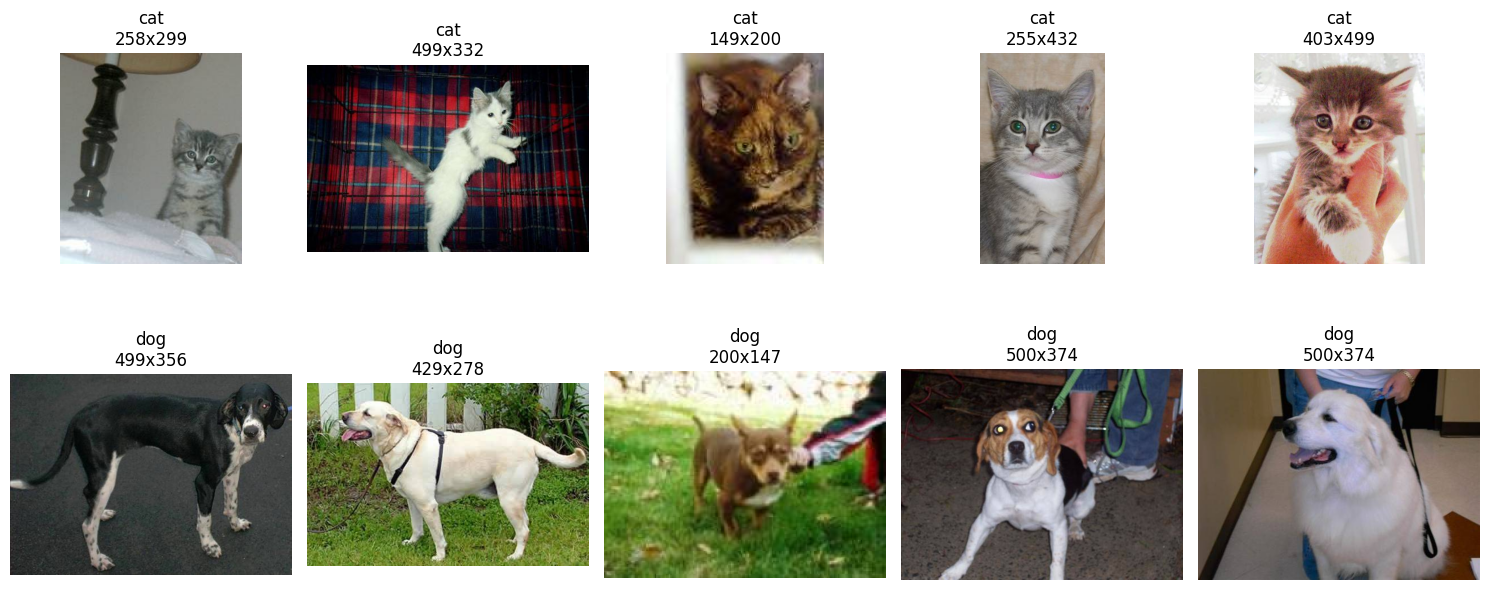

In [9]:
# Path dataset
path = "cat_dog_dataset/dataset/"

# Membuat kamus yang menyimpan daftar nama file gambar untuk setiap kelas
emotion_images = {}
for class_name in os.listdir(path):
    class_path = os.path.join(path, class_name)
    if os.path.isdir(class_path):  # Pastikan hanya folder yang dibaca
        emotion_images[class_name] = os.listdir(class_path)

# Plot 5 gambar acak dari setiap kelas beserta ukurannya
fig, axs = plt.subplots(len(emotion_images.keys()), 5, figsize=(15, 3 * len(emotion_images)))

for i, class_name in enumerate(emotion_images.keys()):
    # Ambil 5 gambar secara acak dari kelas tersebut
    images = np.random.choice(emotion_images[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path, class_name, image_name)
        img = Image.open(img_path).convert("RGB")  # Gunakan warna (atau "L" jika ingin grayscale)
        axs[i, j].imshow(img)
        axs[i, j].set_title(f"{class_name}\n{img.size[0]}x{img.size[1]}")
        axs[i, j].axis("off")

plt.tight_layout()
plt.subplots_adjust(hspace=0.5)
plt.show()

## Plot Distribusi

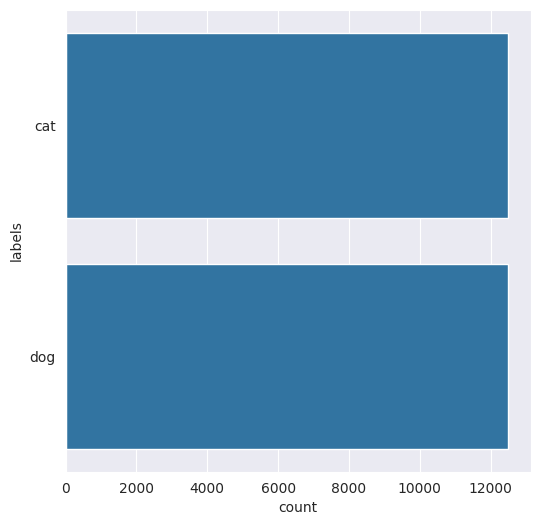

In [10]:
import seaborn as sns

# Definisikan path sumber
lung_path = "cat_dog_dataset/dataset/"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

# Data Augmentation

In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Membuat objek ImageDataGenerator dengan berbagai augmentasi
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,             # Rotasi acak hingga 270 derajat
    brightness_range=[0.8, 1.3],    # Kecerahan acak
    shear_range=0.2,                # Pergeseran melengkung (shear)
    width_shift_range=0.2,         # Pergeseran lebar
    height_shift_range=0.2,        # Pergeseran tinggi
    zoom_range=0.2,                # Zoom acak
    horizontal_flip=True,          # Balik horizontal
    vertical_flip=True,            # Balik vertikal (atas-bawah)
    fill_mode='nearest'            # Metode pengisian setelah transformasi
)

# Contoh penggunaan pada gambar tunggal
def augment_image(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(150, 150))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Ubah jadi batch size 1

    # Menghasilkan batch gambar hasil augmentasi
    augmented_iter = datagen.flow(img_array, batch_size=1)

    # Ambil satu batch hasil augmentasi
    augmented_img = next(augmented_iter)[0].astype('uint8')

    return augmented_img

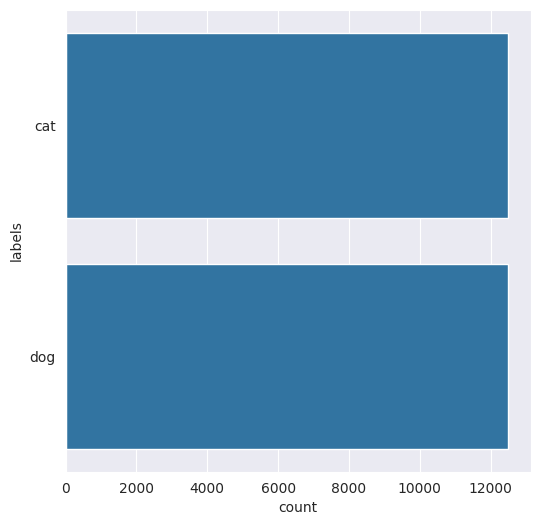

In [12]:
import seaborn as sns

# Definisikan path sumber
lung_path = "cat_dog_dataset/dataset/"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

## Image Generator

In [13]:
import os

BASE_DIR = "cat_dog_dataset/"
sets = ['train', 'val', 'test']

for s in sets:
    print(f"\nJumlah gambar untuk set: {s.upper()}")
    set_path = os.path.join(BASE_DIR, s)

    # Ambil semua label (folder) dalam set ini
    labels = os.listdir(set_path)

    for label in labels:
        label_path = os.path.join(set_path, label)
        if os.path.isdir(label_path):
            count = len(os.listdir(label_path))
            print(f" - {label}: {count} gambar")


Jumlah gambar untuk set: TRAIN
 - cat: 10000 gambar
 - dog: 10000 gambar

Jumlah gambar untuk set: VAL
 - cat: 1250 gambar
 - dog: 1250 gambar

Jumlah gambar untuk set: TEST
 - cat: 1250 gambar
 - dog: 1250 gambar


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path direktori dataset
TRAIN_DIR = "cat_dog_dataset/train/"
VAL_DIR   = "cat_dog_dataset/val/"
TEST_DIR  = "cat_dog_dataset/test/"

# ImageDataGenerator untuk training dan validasi
datagen = ImageDataGenerator(
    rescale=1./255
)

# Test tetap hanya rescale
test_datagen = ImageDataGenerator(rescale=1./255)

# Train Generator
train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    batch_size=32,
    target_size=(150, 150),
    color_mode="rgb",          # karena gambar tanaman berwarna
    class_mode='categorical',  # karena >2 kelas
    shuffle=True
)

# Validation Generator
validation_generator = datagen.flow_from_directory(
    VAL_DIR,
    batch_size=32,
    target_size=(150, 150),
    color_mode="rgb",
    class_mode='categorical',
    shuffle=False
)

# Test Generator
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    batch_size=1,
    target_size=(150, 150),
    color_mode="rgb",
    class_mode='categorical',
    shuffle=False
)

Found 20000 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


## Modeling

In [15]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

# Membuat model Sequential
model = Sequential([
    # Layer 1: Conv2D + MaxPooling
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Layer 2: Conv2D + MaxPooling
    Conv2D(64, (4, 4), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Flatten untuk mengubah ke vektor
    Flatten(),

    # Fully Connected Layer
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),

    # Output Layer (2 kelas)
    Dense(2, activation='softmax')
])

# Kompilasi model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Menampilkan ringkasan model
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 71, 71, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 71, 71, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 35, 35, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 78400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    10,035,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,077,826 (38.44 MB)

 Trainable params: 10,077,634 (38.44 MB)

 Non-trainable params: 192 (768.00 B)

In [16]:
# Definisikan Callback Kustom
class CustomModelCheckpoint(Callback):
    def __init__(self, save_path="saved_model/CNN_Awal", max_gap=0.02, loss_tolerance=0.01):
        super(CustomModelCheckpoint, self).__init__()
        self.save_path = save_path
        self.max_gap = max_gap
        self.loss_tolerance = loss_tolerance
        self.best_val_acc = 0
        self.best_val_loss = float("inf")

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_acc = logs.get("val_accuracy", 0)
        train_acc = logs.get("accuracy", 0)
        val_loss = logs.get("val_loss", float("inf"))

        if (val_acc > self.best_val_acc and abs(train_acc - val_acc) <= self.max_gap
            and val_loss < self.best_val_loss):
            self.best_val_acc = val_acc
            self.best_val_loss = val_loss
            tf.saved_model.save(self.model, self.save_path)
            print(f"Model disimpan di {self.save_path} dengan val_acc: {val_acc:.4f}, val_loss: {val_loss:.4f}, dan gap: {abs(train_acc - val_acc):.4f}")

class CustomEarlyStopping(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_acc = logs.get("val_accuracy", 0)
        train_acc = logs.get("accuracy", 0)

        if val_acc >= 0.96 and train_acc >= 0.96:
            print(f"\nTraining dihentikan karena train_acc ({train_acc:.4f}) dan val_acc ({val_acc:.4f}) >= 0.96")
            self.model.stop_training = True
# Definisikan Callbacks
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
custom_checkpoint = CustomModelCheckpoint(save_path="saved_model/CNN_Awal")
custom_early_stopping = CustomEarlyStopping()

In [17]:
# Training model dengan callbacks
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[reduce_lr, early_stopping, custom_checkpoint, custom_early_stopping],
    verbose=1
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.5254 - loss: 2.2223Model disimpan di saved_model/CNN_Awal dengan val_acc: 0.5028, val_loss: 0.7054, dan gap: 0.0076
625/625 ━━━━━━━━━━━━━━━━━━━━ 50s 67ms/step - accuracy: 0.5253 - loss: 2.2188 - val_accuracy: 0.5028 - val_loss: 0.7054 - learning_rate: 0.0010
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 60ms/step - accuracy: 0.5020 - loss: 0.7034 - val_accuracy: 0.5008 - val_loss: 0.6942 - learning_rate: 0.0010
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 60ms/step - accuracy: 0.4972 - loss: 0.6937 - val_accuracy: 0.5000 - val_loss: 0.7819 - learning_rate: 0.0010
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 58ms/step - accuracy: 0.5040 - loss: 0.6980 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 57ms/step - accuracy: 0.4995 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 59ms/step - accuracy: 0.4

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Path direktori dataset (sesuai dengan kode sebelumnya)
TRAIN_DIR = "cat_dog_dataset/train/"
VAL_DIR   = "cat_dog_dataset/val/"
TEST_DIR  = "cat_dog_dataset/test/"

# Load base model MobileNet (pre-trained pada ImageNet)
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Membekukan layer base model agar tidak dilatih ulang
base_model.trainable = False

# Membuat model Sequential
model = Sequential([
    # Base model (MobileNet)
    base_model,

    # Tambahan Conv2D layer
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),

    # Tambahan MaxPooling layer
    MaxPooling2D(2, 2),

    # Tambahan Conv2D layer kedua
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),

    # Tambahan MaxPooling layer kedua
    MaxPooling2D(2, 2),

    # GlobalAveragePooling untuk mengurangi dimensi
    GlobalAveragePooling2D(),

    # Fully Connected Layer
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),

    # Output Layer (30 kelas sesuai dataset)
    Dense(2, activation='sigmoid')
])

# Kompilasi model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Menampilkan ringkasan model
model.summary()

# Definisikan Callbacks (menggunakan yang sudah ada di kode sebelumnya)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5,min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1)
custom_checkpoint = CustomModelCheckpoint(save_path="saved_model/transfer_learning")
custom_early_stopping = CustomEarlyStopping()

# Training model dengan data generator yang sudah dibuat sebelumnya
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[reduce_lr, early_stopping, custom_checkpoint, custom_early_stopping],
    verbose=1
)

<ipython-input-18-1fe443caee73>:14: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ (None, 4, 4, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │       589,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 2, 2, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2, 2, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,091,266 (15.61 MB)

 Trainable params: 862,018 (3.29 MB)

 Non-trainable params: 3,229,248 (12.32 MB)

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9479 - loss: 0.1310Model disimpan di saved_model/transfer_learning dengan val_acc: 0.9712, val_loss: 0.0690, dan gap: 0.0097

Training dihentikan karena train_acc (0.9615) dan val_acc (0.9712) >= 0.96
625/625 ━━━━━━━━━━━━━━━━━━━━ 54s 71ms/step - accuracy: 0.9480 - loss: 0.1309 - val_accuracy: 0.9712 - val_loss: 0.0690 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.


In [19]:
# Fine-tuning: Membuka beberapa layer base model untuk pelatihan
base_model.trainable = True
for layer in base_model.layers[:-20]:  # Bekukan semua kecuali 20 layer terakhir
    layer.trainable = False

# Kompilasi ulang model dengan learning rate kecil
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Learning rate kecil untuk fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Pelatihan fine-tuning
history_fine = model.fit(
    train_generator,
    epochs=15,  # Jumlah epoch lebih kecil untuk fine-tuning
    validation_data=validation_generator,
    callbacks=[reduce_lr, early_stopping, custom_checkpoint, custom_early_stopping],
    verbose=1
)

Epoch 1/15
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9585 - loss: 0.1242
Training dihentikan karena train_acc (0.9601) dan val_acc (0.9672) >= 0.96
625/625 ━━━━━━━━━━━━━━━━━━━━ 54s 65ms/step - accuracy: 0.9585 - loss: 0.1242 - val_accuracy: 0.9672 - val_loss: 0.0887 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 1.


## Evaluasi dan Visualisasi

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step

Classification Report:
              precision    recall  f1-score   support

         cat       0.97      0.96      0.96      1250
         dog       0.96      0.97      0.96      1250

    accuracy                           0.96      2500
   macro avg       0.96      0.96      0.96      2500
weighted avg       0.96      0.96      0.96      2500



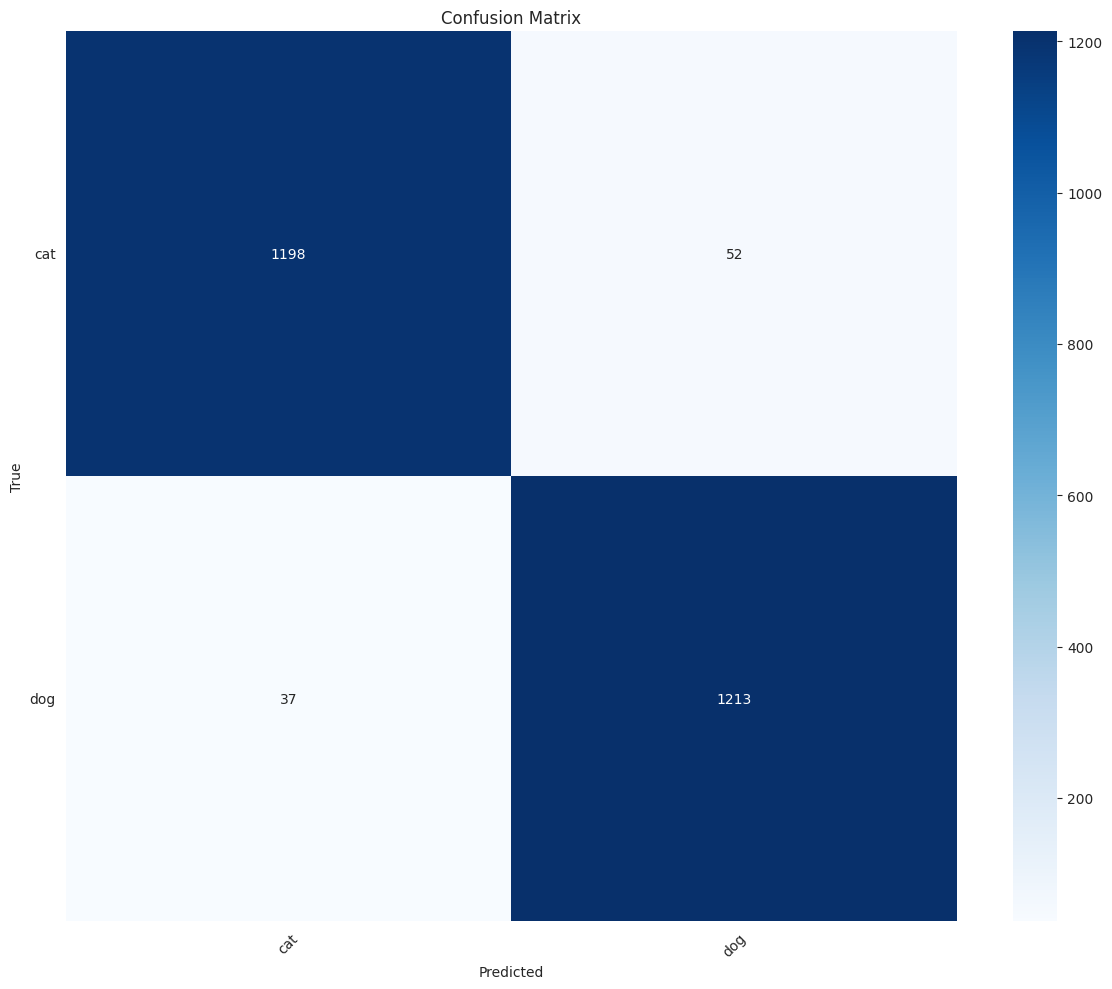

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Prediksi pada test set untuk analisis lebih lanjut
test_generator.reset()  # Reset generator untuk memastikan urutan data benar
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification Report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

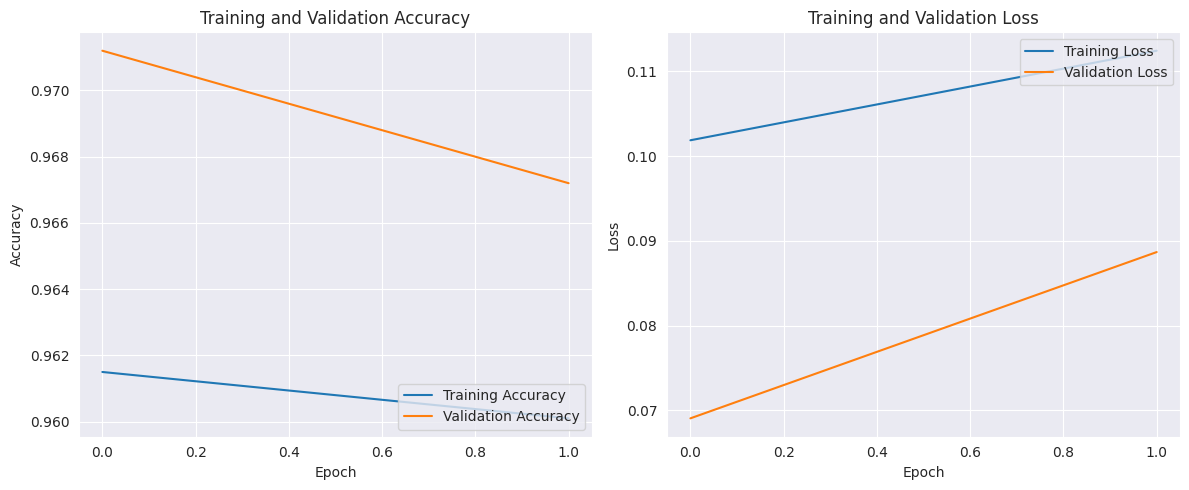

In [21]:
# == Visualisasi Akurasi dan Loss ==
# Menggabungkan history dari pelatihan awal dan fine-tuning
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']
epochs_range = range(len(acc))

# Plot Akurasi
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Konversi Model

In [22]:
import tensorflow as tf
import os

# == 1. Menyimpan Model dalam Format SavedModel ==
# Direktori untuk menyimpan SavedModel
saved_model_dir = "saved_model/transfer_learning_final"
tf.saved_model.save(model, saved_model_dir)
print(f"Model berhasil disimpan dalam format SavedModel di: {saved_model_dir}")

Model berhasil disimpan dalam format SavedModel di: saved_model/transfer_learning_final


In [23]:
# == 2. Konversi ke Format TF-Lite ==

converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Mengaktifkan optimasi default (opsi ini membantu mengurangi ukuran model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Konversi model
tflite_model = converter.convert()

# Simpan model TF-Lite ke file
tflite_model_path = "model.tflite"
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)
print(f"Model berhasil dikonversi ke format TF-Lite dan disimpan di: {tflite_model_path}")

Saved artifact at '/tmp/tmp_ja7viwb'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_99')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  138387555649104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138387555648720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138387555650448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138387555648336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138387566788432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138387555650064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138387498610000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138387498610768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138387498610384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138387498613264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13838749861

In [24]:
labels = list(train_generator.class_indices.keys())
with open('labels.txt', 'w') as f:
  for label in labels:
    f.write(label + '\n')

In [25]:
# == 3. Konversi ke Format TFJS ==
import tensorflowjs as tfjs

# Direktori untuk menyimpan model TFJS
tfjs_model_dir = "tfjs_model"

# Konversi model ke format TFJS
tfjs.converters.save_keras_model(model, tfjs_model_dir)
print(f"Model berhasil dikonversi ke format TFJS dan disimpan di: {tfjs_model_dir}")

failed to lookup keras version from the file,
    this is likely a weight only file
Model berhasil dikonversi ke format TFJS dan disimpan di: tfjs_model


# Inference (Optional)

Hasil Inferensi menggunakan TF-lite:
Kelas yang Diprediksi: dog
Probabilitas: 1.0000


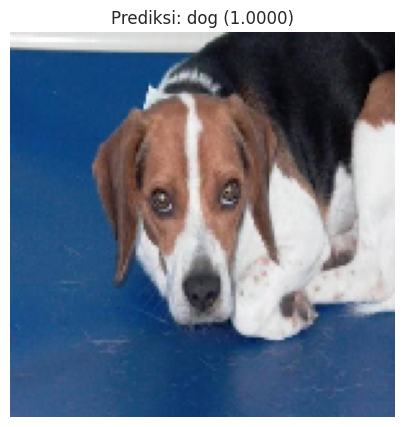

In [28]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# == Inference Menggunakan Model TF-Lite ==

# 1. Memuat model
saved_model_path = "model.tflite"
interpreter = tf.lite.Interpreter(model_path=saved_model_path)
interpreter.allocate_tensors()

# Mendapatkan detail input dan output dari model
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# 2. Memuat dan memproses gambar untuk inferensi
# Ganti path ini dengan path gambar dari dataset test Anda
image_path = "cat_dog_dataset/test/dog/dog.6542.jpg"  # Contoh path gambar
image = load_img(image_path, target_size=(150, 150))  # Sesuaikan dengan ukuran input model
image_array = img_to_array(image)
image_array = image_array / 255.0  # Normalisasi (sesuai dengan preprocessing saat pelatihan)
image_array = np.expand_dims(image_array, axis=0)  # Tambah dimensi batch (1, 150, 150, 3)

# 3. Melakukan inferensi
# Set input tensor
interpreter.set_tensor(input_details[0]['index'], image_array)
# Jalankan inferensi
interpreter.invoke()
# Ambil output
predictions = interpreter.get_tensor(output_details[0]['index'])
predicted_class_index = np.argmax(predictions, axis=1)[0]
predicted_probability = predictions[0][predicted_class_index]

# 4. Mendapatkan label kelas
# Daftar kelas sesuai dengan dataset (sesuai urutan class_indices dari generator)
class_labels = list(test_generator.class_indices.keys())
predicted_class = class_labels[predicted_class_index]

# 5. Menampilkan hasil inferensi
print(f"Hasil Inferensi menggunakan TF-lite:")
print(f"Kelas yang Diprediksi: {predicted_class}")
print(f"Probabilitas: {predicted_probability:.4f}")

# Menampilkan gambar beserta prediksi
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.title(f"Prediksi: {predicted_class} ({predicted_probability:.4f})")
plt.axis('off')
plt.show()

Hasil Inferensi menggunakan TF-lite:
Kelas yang Diprediksi: cat
Probabilitas: 1.0000


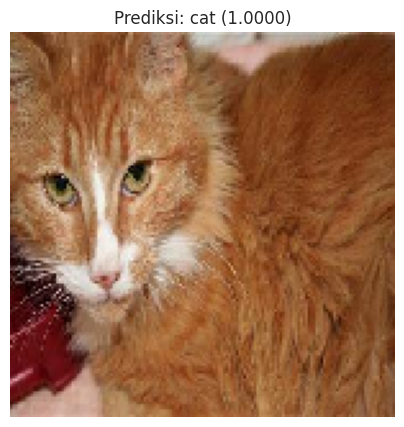

In [29]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# == Inference Menggunakan Model TF-Lite ==

# 1. Memuat model
saved_model_path = "model.tflite"
interpreter = tf.lite.Interpreter(model_path=saved_model_path)
interpreter.allocate_tensors()

# Mendapatkan detail input dan output dari model
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# 2. Memuat dan memproses gambar untuk inferensi
# Ganti path ini dengan path gambar dari dataset test Anda
image_path = "cat_dog_dataset/test/cat/cat.7133.jpg"  # Contoh path gambar
image = load_img(image_path, target_size=(150, 150))  # Sesuaikan dengan ukuran input model
image_array = img_to_array(image)
image_array = image_array / 255.0  # Normalisasi (sesuai dengan preprocessing saat pelatihan)
image_array = np.expand_dims(image_array, axis=0)  # Tambah dimensi batch (1, 150, 150, 3)

# 3. Melakukan inferensi
# Set input tensor
interpreter.set_tensor(input_details[0]['index'], image_array)
# Jalankan inferensi
interpreter.invoke()
# Ambil output
predictions = interpreter.get_tensor(output_details[0]['index'])
predicted_class_index = np.argmax(predictions, axis=1)[0]
predicted_probability = predictions[0][predicted_class_index]

# 4. Mendapatkan label kelas
# Daftar kelas sesuai dengan dataset (sesuai urutan class_indices dari generator)
class_labels = list(test_generator.class_indices.keys())
predicted_class = class_labels[predicted_class_index]

# 5. Menampilkan hasil inferensi
print(f"Hasil Inferensi menggunakan TF-lite:")
print(f"Kelas yang Diprediksi: {predicted_class}")
print(f"Probabilitas: {predicted_probability:.4f}")

# Menampilkan gambar beserta prediksi
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.title(f"Prediksi: {predicted_class} ({predicted_probability:.4f})")
plt.axis('off')
plt.show()

In [33]:
!pip freeze > requirements.txt

In [38]:
!zip -r /content/saved_model.zip /content/saved_model
!zip -r /content/tfjs_model.zip /content/tfjs_model

updating: content/saved_model/ (stored 0%)
updating: content/saved_model/CNN_Awal/ (stored 0%)
updating: content/saved_model/CNN_Awal/fingerprint.pb (stored 0%)
updating: content/saved_model/CNN_Awal/assets/ (stored 0%)
updating: content/saved_model/CNN_Awal/variables/ (stored 0%)
updating: content/saved_model/CNN_Awal/variables/variables.index (deflated 66%)
updating: content/saved_model/CNN_Awal/variables/variables.data-00000-of-00001 (deflated 7%)
updating: content/saved_model/CNN_Awal/saved_model.pb (deflated 88%)
updating: content/saved_model/transfer_learning/ (stored 0%)
updating: content/saved_model/transfer_learning/fingerprint.pb (stored 0%)
updating: content/saved_model/transfer_learning/assets/ (stored 0%)
updating: content/saved_model/transfer_learning/variables/ (stored 0%)
updating: content/saved_model/transfer_learning/variables/variables.index (deflated 76%)
updating: content/saved_model/transfer_learning/variables/variables.data-00000-of-00001 (deflated 7%)
updating: 